# Notebook to calculate homeranges and create final dataframes

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import rasterio
import geopandas as geopd
import rasterio.rio
import seaborn as sns
import datetime as dt 

from rasterio.plot import show
from scipy.spatial import ConvexHull

import pyreadr



First, read in the cleaned data

In [2]:
foxes_all = geopd.read_file("../data/cleaned_shapefiles/foxes_all.shp")
foxes_resamp = geopd.read_file("../data/cleaned_shapefiles/foxes_resamp.shp")
sample_points = geopd.read_file("../data/cleaned_shapefiles/sample_points.shp")


Build infiv_fox_all, which contains all data for each individual fox

In [3]:
indiv_fox_all = {}
for i in foxes_all.id.unique():
    indiv_fox_all[i] = foxes_all[foxes_all.id == i]

In [4]:
foxes = list(indiv_fox_all.values())


Building indiv_fox_resamp, which contains the resampled data for each individual fox

In [5]:
indiv_fox_resamp = {}
for i in foxes_resamp.id.unique():
    indiv_fox_resamp[i] = foxes_resamp[foxes_resamp.id == i]

In [6]:
foxes_indiv_resamp = list(indiv_fox_resamp.values())

## __Function Definition for Home Range plotting__
Now we define the necessary functions to calculate and plot the homeranges

In [7]:
def homerange_plot_mean(xy, n_drop):
    '''
    Function to calculate the homerange.
    Input values are a series with the positional data as 
    well as the amount of positions that should be removed.
    To remove the positions, the mean of all positions is calculated. 
    The positions with the biggest distance to this mean are deleted.
    The return value is the array with the reduced amount of positions.
    '''
    #sort points by distance to mean
    ind_list = np.linalg.norm(xy - np.mean(xy, axis = 0, keepdims=True), axis = 1).argsort()
    xy_sorted = xy[ind_list, :]

    #drop last n-drop values, calculate hull
    xy_hr = xy_sorted[:-n_drop,...]
    hull = ConvexHull(xy_hr)
    
    return xy_hr

def homerange_plot_min_volume(xy, n_drop):
    '''
    Function to calculate the homerange.
    Input values are a dataframe where the x- and y- values
    of the position are stored in the first two columns as
    well as the amount of positions that should be removed.
    The total amount of positions is reduced in a way such 
    that the volume of the ConvexHull is as small as possible.
    The return value is the array with the reduced amount of positions.
    '''
    #loop for every row that will be dropped:
    for k in range(n_drop):
        #create lists
        vol = []
        index = []
        #get points that make up the ConvexHull and store them in points
        #these are the points that could be dropped to reduce the volume
        hull = ConvexHull(xy)
        points = hull.vertices
        #loop over points: drop each one and store both the resulting volume and the index of the point in a list
        for i in points:
            xy_drop = np.delete(xy, i, 0)
            hull = ConvexHull(xy_drop)
            vol.append(hull.volume)
            index.append(i)
        #find the smallest volume and the corresponding index
        smallest = min(vol)
        index_smallest = vol.index(smallest)
        del_index = index[index_smallest]
        #drop the row with this index from the array
        xy = np.delete(xy,del_index,0)
    return xy

def homerange_proportion(data, proportion = 0.95):
    '''
    Main function to calculate the homerange.
    Input values are a dataframe where the x- and y- values of
    the position are stored in the first two columns as well as the
    proportion of positions that should be used for the homerange.
    The function calls the two functions homerange_plot_mean and 
    homerange_plot_min_volume, calculates the final hull and plots it.
    The return value is the array with the reduced amount of positions.
    '''
    #create array out of input data
    xy = np.array(data.iloc[:,0:2].to_numpy())
    #estimate how many rows need to be dropped
    n_drop = int(np.ceil(xy.shape[0]*(1-proportion)))

    #distribute n_drop between the two functions
    if (proportion < 0.97):
        n_drop_min_volume = int(np.ceil(xy.shape[0]*0.03))
    else:
        n_drop_min_volume = n_drop-1
    n_drop_mean = n_drop - n_drop_min_volume

    # use homerange_plot_min_volume and homerange_plot_mean to build
    # the data frame including only the points used to build the 
    # home range
    xy_new = homerange_plot_min_volume(xy, n_drop_min_volume)
    xy_proportion = homerange_plot_mean(xy_new, n_drop_mean)

    return xy, xy_proportion

def homerange_plot(data, proportion = 0.95):
    '''
    Function to plot the home ranges. Takes in two arguments:
    data: should include an x and y column at first and second place
    proportion: the proportion of points that should be used to build
    the home ranges

    Uses the homerange_proportion() function to create new array only
    including the proportion of points of the input data frame that was
    specified. It then calculates the hull and plots it.

    Returns:
    hull object
    '''
    xy, xy_new = homerange_proportion(data, proportion)

    hull = ConvexHull(xy_new)
    f, ax = plt.subplots()
    ax.plot(xy[:,0], xy[:,1], 'o')
    for simplex in hull.simplices:
        ax.plot(xy_new[simplex, 0], xy_new[simplex, 1], 'k-')
    plt.show()


def homerange_geometry_df(data, proportion = 0.95):
    '''
    Function to build a data frame including the geometry out of the 
    output of homerange_proportion(). 
    
    Input:
    data: dataframe where the x- and y- values of the position are stored
    in the first two columns
    proportion: proportion of positions that should be used for the homerange.

    The function calls the homerange_proportion function and uses the return 
    to build the convex hull of the data points. 

    Return:
    A data frame including the geometry of the input data and the id of the input data.
    The convex hull
    '''
    xy, xy_new = homerange_proportion(data, proportion)
    hull = ConvexHull(xy_new)


    xy_df = geopd.GeoDataFrame(xy_new, geometry=geopd.points_from_xy(xy_new[:,0], xy_new[:,1]), columns = ["x", "y"])
    xy_df["id"] = data["id"][data["id"].first_valid_index()]
    xy_df["area"] = hull.volume
    xy_df = xy_df.drop(["x","y"], axis = 1)

    return xy_df

def homerange_area(data, proportion = 0.95):
    '''
    Main function to calculate the polygons of the home ranges.

    Input: 
    data: dataframe where the x- and y- values of the position are stored
    in the first two columns
    proportion: proportion of positions that should be used for the homerange.
    proportion of positions that should be used for the homerange.

    The function calls the homerange_proportion function.

    Returns:
    convex hull of the input geometry
    '''

    xy, xy_new = homerange_proportion(data, proportion)
    
    xy_new = geopd.GeoDataFrame(xy_new, geometry=geopd.points_from_xy(xy_new[:,0], xy_new[:,1]), columns = ["x", "y"])
    xy_new["id"] = data["id"][data["id"].first_valid_index()]
    xy_new = xy_new.drop(["x","y"], axis = 1)
    xy_geometry = xy_new.unary_union.convex_hull

    return xy_geometry

#### __Plotting the Home Ranges__

For the foxes with all points.

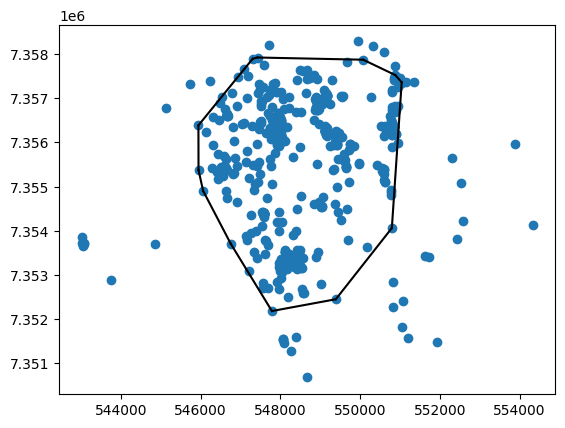

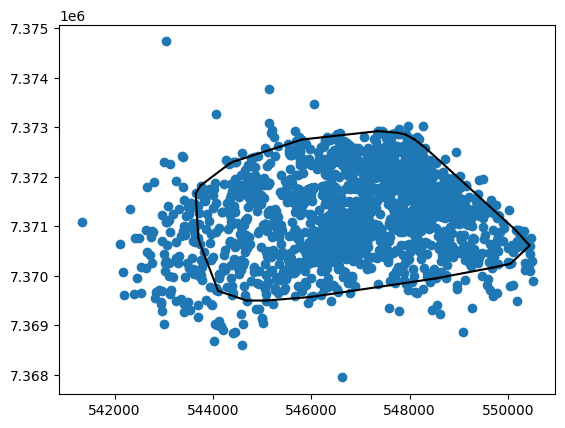

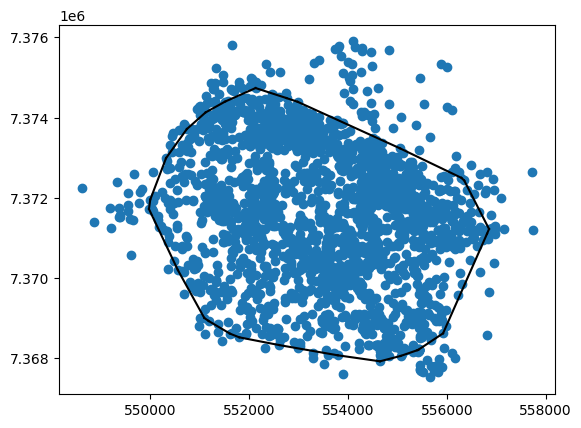

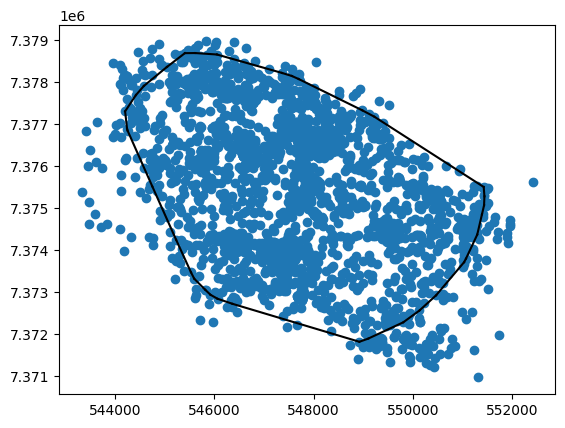

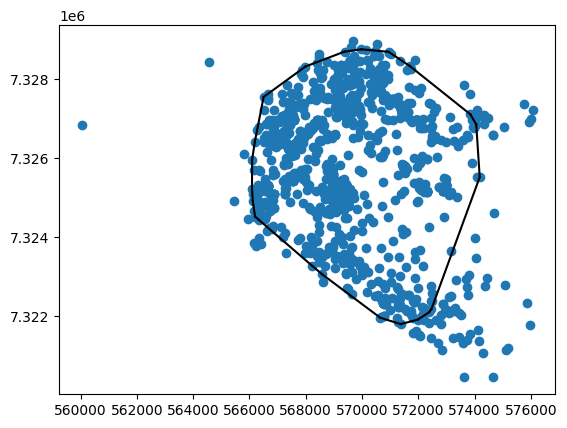

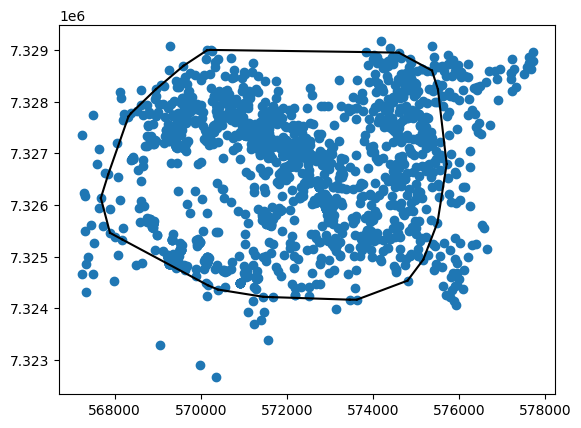

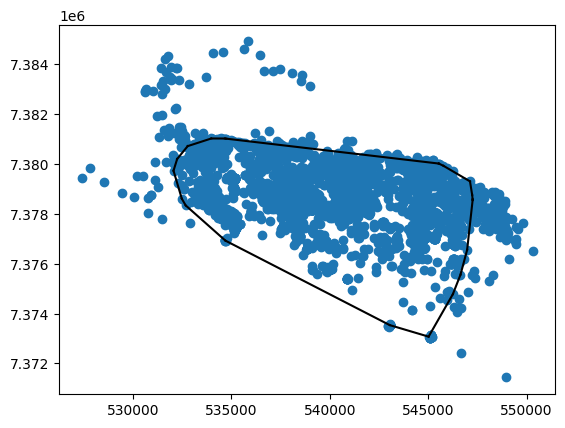

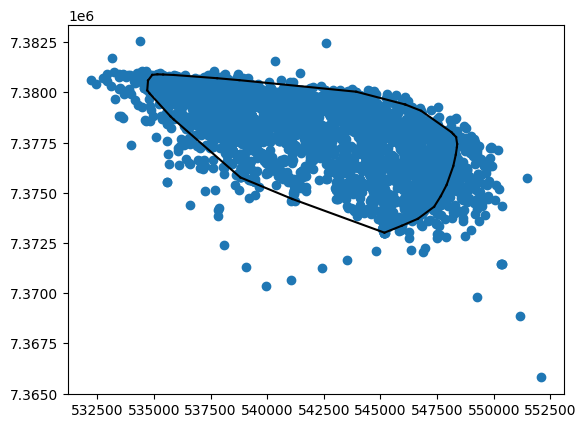

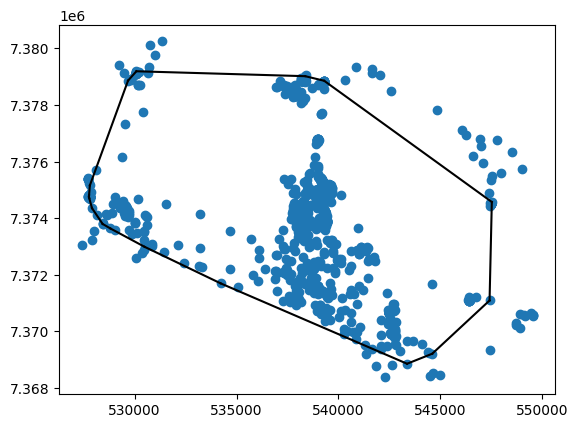

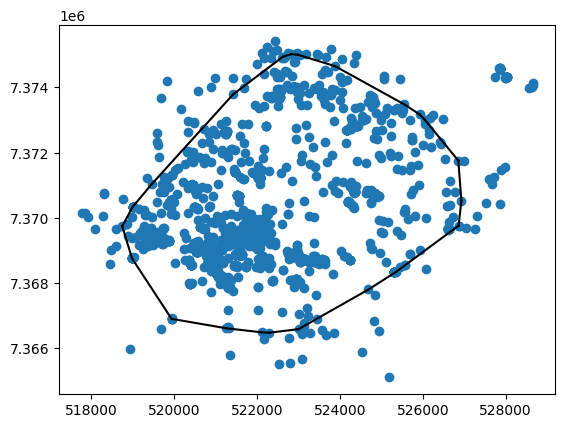

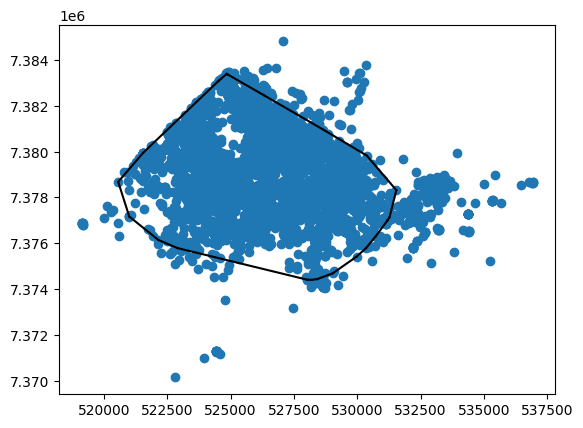

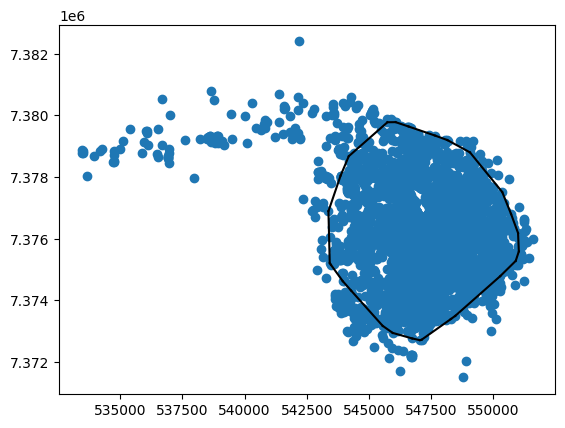

In [8]:
for i in foxes:
    homerange_plot(i, 0.95)

For the foxes with the resampled points

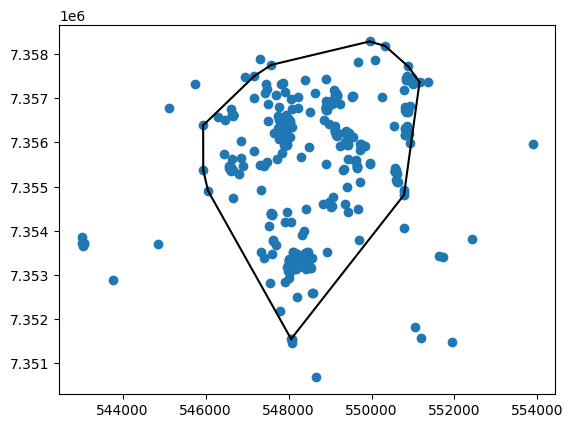

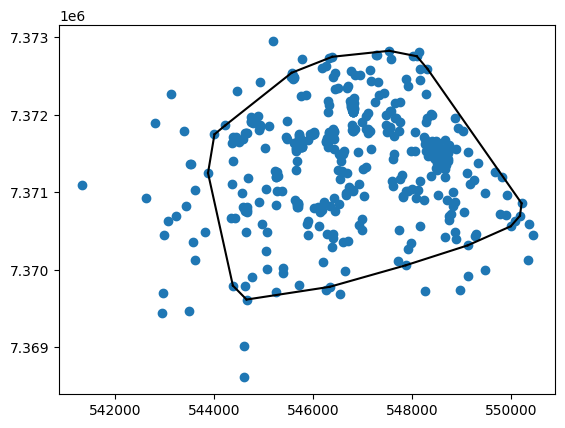

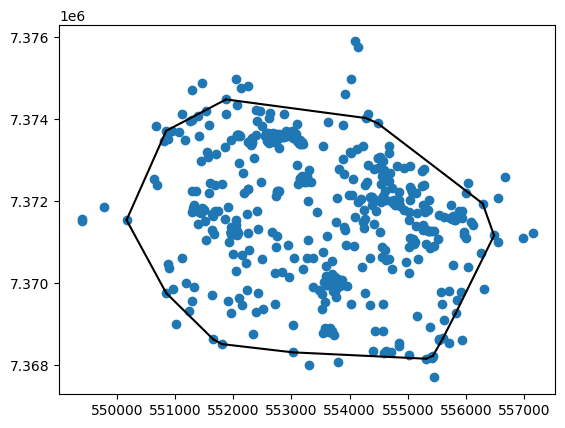

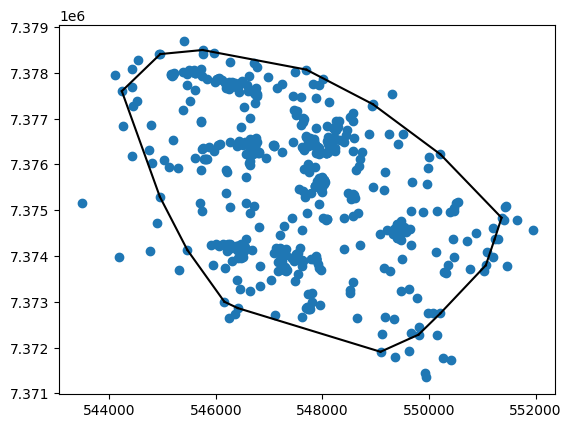

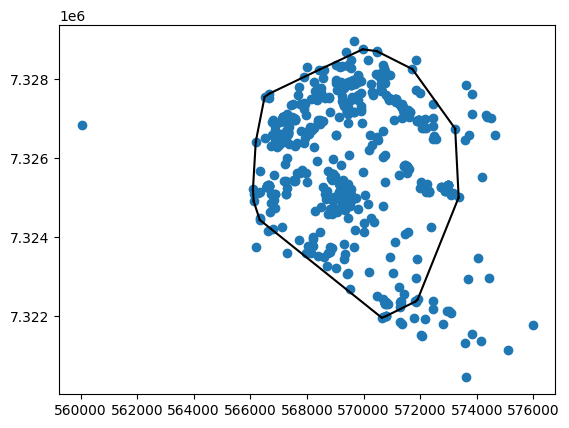

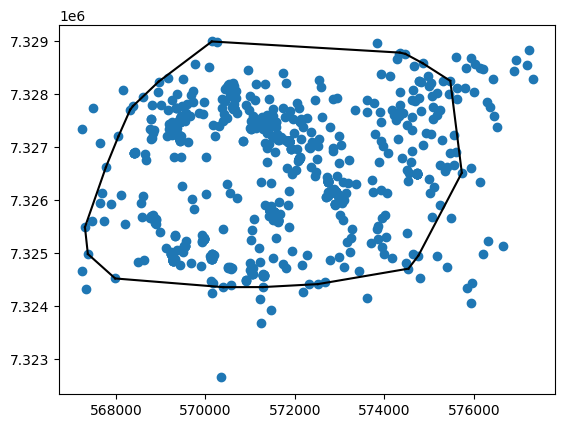

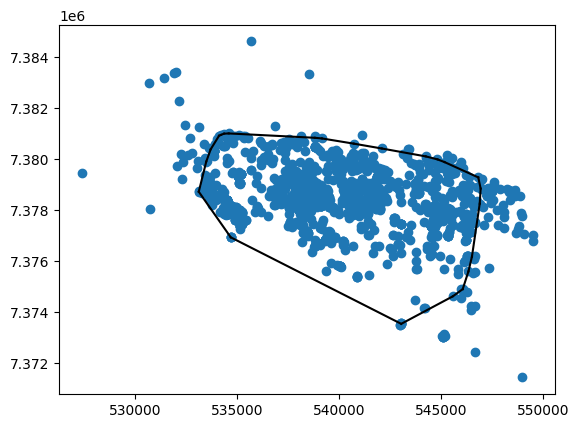

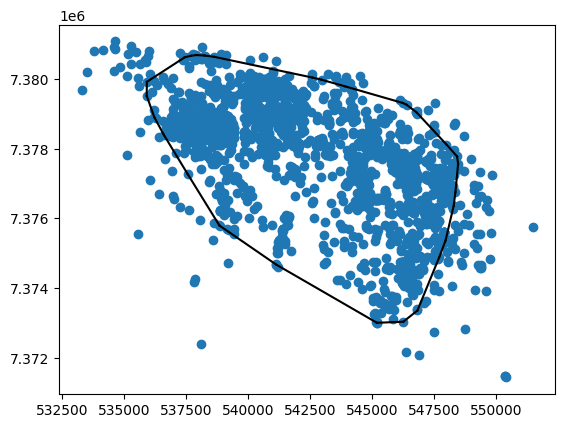

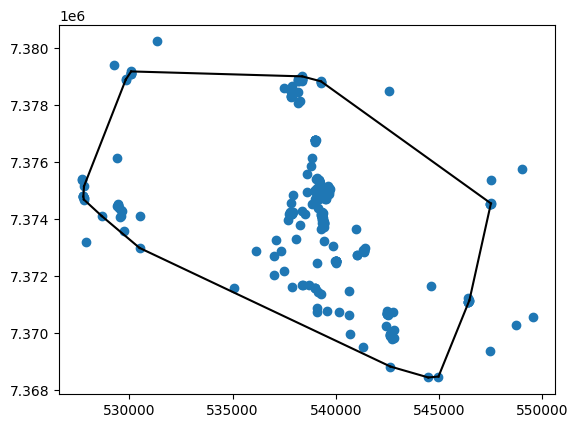

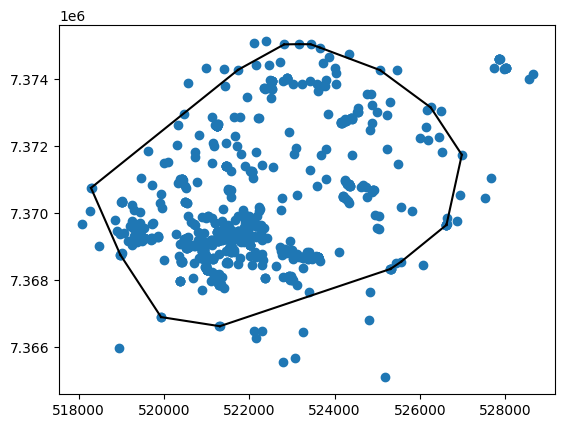

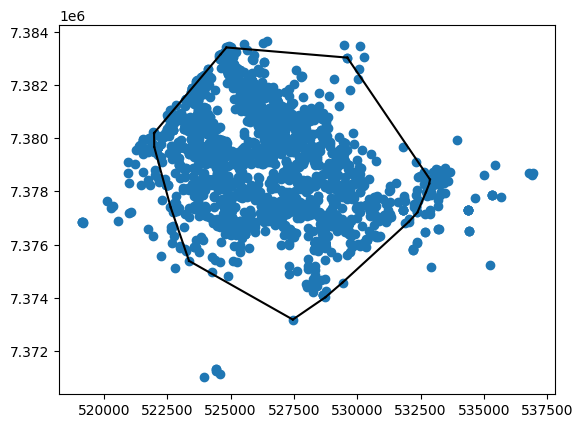

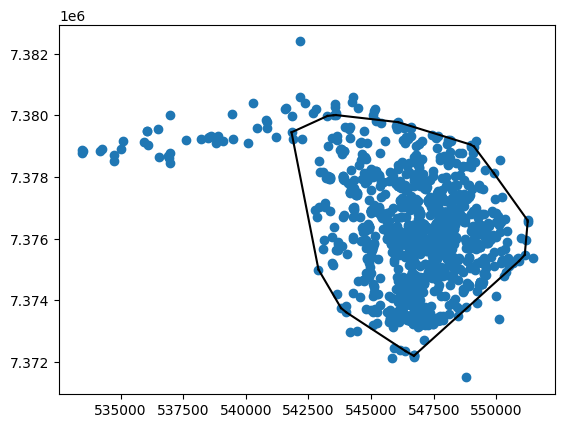

In [9]:
for i in foxes_indiv_resamp:
    homerange_plot(i, 0.95)

## __Final Data Frame for all Foxes__

### Creating the Geometries for the Home Ranges

In [10]:
fox_area = [homerange_geometry_df(fox, 0.95) for fox in foxes]
fox_hulls = [homerange_area(fox, 0.95) for fox in foxes]

### Deleting the Points within the Home Ranges from the Sample Points

In [11]:
sample_points_all = sample_points.copy()
for fox in fox_hulls:
    sample_points_all = sample_points_all.difference(fox)

### Processing the Data Frames for the Sample Points and the Foxes

#### Creating Data Frame for Foxes

The resulting data frame will only include the GPS data points of the foxes, that lie within the home range areas of these foxes. 

In [12]:
foxes_all = []
for i in range(0,len(foxes)-1):
    if i == 0:
        foxes_all = pd.concat([foxes[i], foxes[i+1]])
    else:
        foxes_all = pd.concat([foxes_all, foxes[i+1]])

In [13]:
fox_all = []
for i in range(0,len(fox_area)-1):
    if i == 0:
        fox_all = pd.concat([fox_area[i], fox_area[i+1]])
    else:
        fox_all = pd.concat([fox_all, fox_area[i+1]])

In [14]:
fox_all_merged = foxes_all.merge(fox_all, on = ["geometry", "id"])

#### Creating Data Frame for Sample Points

The resulting data frame will only include the GPS points of the sample points that lie outside of the home range areas of the foxes. 

In [15]:
sample_points_df = geopd.GeoDataFrame(geometry = sample_points_all)

In [16]:
sample_points_all_merged = sample_points.merge(sample_points_df, on = "geometry")
sample_points_all_merged.shape

(479040, 10)

### Combining the Data Frames into Final Data Frame for all Foxes

First the value for the target variable is put into a column in both data frames. Further, we set the id for the sample points to "available", as these are the points that were available to the foxes, but not used in their home ranges. Further we rename "x" and "y" in the sample points to match "x_" and "y_" in the fox data frame.

In [17]:
fox_all_merged["target"] = 1


sample_points_all_merged["target"] = 0
sample_points_all_merged["id"] = "available"
sample_points_all_merged = sample_points_all_merged.rename(columns = {"x" : "x_",
                                            "y" : "y_"})

Then we concatenate both data frames, resulting in a combined data frame, with NaN values in the target = 0 columns for timestamp, sex and t_, as we do not have meaningful values for available points for these features.

In [18]:
df_all = pd.concat([fox_all_merged, sample_points_all_merged])

And finally we export the resulting data frame as shapefile for use in future notebooks.

In [19]:
df_all.to_file("../data/final_shapefiles/foxes_modelling_all.shp")


## __Final Data Frame for resampled Foxes__

### Creating the Geometries for the Home Ranges

In [20]:
fox_area_resamp = [homerange_geometry_df(fox, 0.95) for fox in foxes_indiv_resamp]
fox_hulls_resamp = [homerange_area(fox, 0.95) for fox in foxes_indiv_resamp]

### Deleting the Points within the Home Ranges from the Sample Points

In [21]:
sample_points_resamp = sample_points.copy()
for fox in fox_hulls_resamp:
    sample_points_resamp = sample_points_resamp.difference(fox)

### Processing the Data Frames for the Sample Points and the resampled Foxes

#### Creating Data Frame for Foxes

The resulting data frame will only include the GPS data points of the foxes, that lie within the home range areas of these foxes. 

In [22]:
foxes_resamp = []
for i in range(0,len(foxes_indiv_resamp)-1):
    if i == 0:
        foxes_resamp = pd.concat([foxes_indiv_resamp[i], foxes_indiv_resamp[i+1]])
    else:
        foxes_resamp = pd.concat([foxes_resamp, foxes_indiv_resamp[i+1]])

In [23]:
fox_resamp = []
for i in range(0,len(fox_area_resamp)-1):
    if i == 0:
        fox_resamp = pd.concat([fox_area_resamp[i], fox_area_resamp[i+1]])
    else:
        fox_resamp = pd.concat([fox_resamp, fox_area_resamp[i+1]])

In [24]:
fox_resamp_merged = foxes_resamp.merge(fox_resamp, on = ["geometry", "id"])
fox_resamp_merged.shape

(14053, 14)

#### Creating Data Frame for Sample Points

The resulting data frame will only include the GPS points of the sample points that lie outside of the home range areas of the foxes. 

In [25]:
sample_resamp_df = geopd.GeoDataFrame(geometry = sample_points_resamp)

In [26]:
sample_points_resamp_merged = sample_points.merge(sample_resamp_df, on = "geometry")
sample_points_resamp_merged.shape

(478412, 10)

In [27]:
sample_points_resamp_merged = sample_points_resamp_merged.iloc[::5, :]
sample_points_resamp_merged.shape

(95683, 10)

### Combining the Data Frames into Final Data Frame for resampled Foxes

First the value for the target variable is put into a column in both data frames. Further, we set the id for the sample points to "available", as these are the points that were available to the foxes, but not used in their home ranges. Further we rename "x" and "y" in the sample points to match "x_" and "y_" in the fox data frame.

In [28]:
fox_resamp_merged["target"] = 1


sample_points_resamp_merged["target"] = 0
sample_points_resamp_merged["id"] = "available"
sample_points_resamp_merged = sample_points_resamp_merged.rename(columns = {"x" : "x_",
                                            "y" : "y_"})

Then we concatenate both data frames, resulting in a combined data frame, with NaN values in the target = 0 columns for timestamp, sex and t_, as we do not have meaningful values for available points for these features.

In [29]:
df_resamp = pd.concat([fox_resamp_merged, sample_points_resamp_merged])
df_resamp.head()

,x_,y_,t_,id,sex,NDVI,NDMI,soil,veg,slope,aspect,elev,geometry,area,target
0,548522.717454,7.353167e+06,2018-07-10-01:56:30,2018-FSBD608-001,F,0.662722,0.125608,Moraine,Dry Shrub,10.135784,205.492111,1033.016602,POINT (548522.717 7353166.639),2.224528e+07,1
1,548525.680513,7.353168e+06,2018-07-10-06:56:32,2018-FSBD608-001,F,0.662722,0.125608,Moraine,Dry Shrub,10.135784,205.492111,1033.016602,POINT (548525.681 7353168.363),2.224528e+07,1
2,548539.963810,7.353164e+06,2018-07-10-11:56:32,2018-FSBD608-001,F,0.662722,0.125608,Moraine,Dry Shrub,10.135784,205.492111,1033.016602,POINT (548539.964 7353164.150),2.224528e+07,1
3,548195.507163,7.352493e+06,2018-07-10-22:31:11,2018-FSBD608-001,F,0.443307,-0.138425,Stone,Grassland,10.065748,339.629059,1072.429321,POINT (548195.507 7352493.197),2.224528e+07,1
4,548558.891944,7.352589e+06,2018-07-11-13:31:01,2018-FSBD608-001,F,0.504280,-0.113833,Stone,Grassland,12.232175,6.898972,1056.955200,POINT (548558.892 7352588.648),2.224528e+07,1


In [30]:
df_resamp.shape

(109736, 15)

And finally we export the resulting data frame as shapefile for use in future notebooks.

In [31]:
df_resamp.to_file("../data/final_shapefiles/foxes_modelling_resamp.shp")
